# DATA ACQUISITION AND MANIPULATION
Retrieval and shaping of data from the NeedleDrop dataset and Spotify API

### Step 1: Get NeedleDrop Data

In [ ]:
#import data science tools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('seaborn-darkgrid')

In [2]:
#Get the NeedleDrop ratings in a pandas DataFrame and manipulate it to bettwe suit our needs
nd = pd.read_csv('./all_needledrop_ratings.csv')

#Set column names
nd.columns = ['artist','album','score','review year']

#drop review year column. This column contains very incomplete data and we can get better data from the spotify API
nd.drop(labels='review year', axis='columns',inplace=True)

#drop first 2 rows
nd.drop(labels=[0,1],axis='index',inplace=True)

#set rating of all albums with rating "classic" or "CLASSIC" to 10
nd.replace(to_replace=['CLASSIC','classic'],value='10', inplace=True)

#remove all rows with weird ratings. For example, we can't assign "meh" a numerical value without guessing and potentially skewing the data
nd = nd[nd['score'].apply(lambda x: x.isdigit())]

#replace scores with numerical data
dic = {'10':10,'9':9,'8':8,'7':7,'6':6,'5':5,'4':4,'3':3,'2':2,'1':1,'0':0}
nd.replace(dic, inplace=True)
nd

,artist,album,score
2,System of a Down,Toxicity,10
3,Burial,Untrue,10
4,Cannibal Ox,The Cold Vein,10
5,Sleater-Kinney,The Woods,10
6,The Postal Service,Give Up,10
...,...,...,...
1991,Broken Bells,Broken Bells,5
1992,Liars,Sisterworld,6
1993,High On Fire,Snakes for the Divine,8
1994,The Knife,Tomorrow In a Year,3


---
The NeedleDrop data is now suitable for analysis, but there isn't much to be learned from this data alone. Here is some basic data exploration that can be done with the NeedleDrop dataset. Beyond this, we need to combine this data with other data.

In [3]:
nd.describe()

,score
count,1858.000000
mean,6.431109
std,1.646079
min,0.000000
25%,5.000000
50%,7.000000
75%,8.000000
max,10.000000


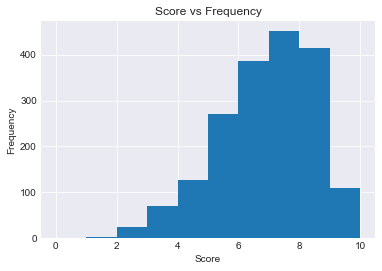

In [4]:
#histogram of scores
plt.hist(nd['score'],bins=10)
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Score vs Frequency")
plt.show()

In [5]:
#The NeedleDrop top 10 artists by most frequent appearances
n = 10
top = nd['artist'].value_counts()[:n].index.tolist()
top_artists = pd.DataFrame(columns=['artist','album','score'])
for a in top:
    top_artists = pd.concat([top_artists, nd[nd['artist'] == a]])
top_artists['artist'].value_counts()

Death Grips                         8
Various Artists                     7
Big K.R.I.T.                        7
Logic                               6
The Weeknd                          6
Vince Staples                       5
Lupe Fiasco                         5
King Gizzard & The Lizard Wizard    5
Mount Eerie                         5
The Underachievers                  5
Name: artist, dtype: int64

### Step 2. Get Spotify Data

In [6]:
#import spotify api client
import csv
from spotify_client import Spotify_client
from album import Album
from ipypb import track as pb
from os.path import getsize

In [7]:
# create client
client = Spotify_client()

#gather raw Spotify album data of albums from list of album names included in NeedleDrop data
raw_albums = []
flagged_albums = []
missed_albums = [] #to look for commonalities in missed searches (maybe we can recover some of this data)
print('Gathering raw album data')
#for album, artists in zip(pb(nd['album'].tolist()),nd['artist'].tolist()):
for index, row in pb(nd.iterrows(),len(nd.index)):
    album = row['album']
    artists = row['artist']
    score = row['score']
    
    album = str(album).strip()
    artists = artists.split(", ")
    a_temp = []
    for a in artists:
        a_temp.append(str(a).strip())
    artists = a_temp
    try:
        flag, search = client.search_for_album(album,artists)
        #successful search
        if flag == 0:
            search['score'] = score
            raw_albums.append(search)
        #flagged search (returned album might be incorrect)
        elif flag == -1:
            search['score'] = score
            flagged_albums.append(((album,artists),search))
        #failed search (no album returned matching search query)
        elif flag == -2:
            missed_albums.append((album,artists))
    except Exception as e:
        print('\t',"exception occured during search for", album, "by", artists, ":", str(e))
raw_albums = [a for a in raw_albums if a] 
print(len(raw_albums) + len(flagged_albums) ," raw albums collected")

Gathering raw album data


 [████████████████████████████████████████████████████████████] 1858/1858 [03:44<00:00, 0.12s/it]

1821  raw albums collected


In [8]:
#at this stage, the missed albums either weren't on spotify or had spelling errors
#all spelling errors were corrected
print(len(missed_albums))

37


In [10]:
#There are still some flagged albums after the search algorithm resolves
#This is an optional checker that allows for manual verification of flagged albums
print("input -> search result")
for album in flagged_albums:
    print(album[0][0], "by", album [0][1], "->", album[1]['name'], "by", album[1]['artists'][0]['name'], end=" >> ")
    ans = input ("correct? [y/N]: ")
    while ans != "y" and ans != "N":
        ans = input("invalid input, enter [y/N]: ")
    if ans == "y":
        raw_albums.append(album[1])
        flagged_albums.remove(album)
    else:
        missed_albums.append(album[1])

input -> search result
Magnus by ['Thou'] -> My Love Is Gone (MAGNUS Remix) by Jonas Aden >> 

correct? [y/N]:  N


Tierra Whack by ['Tierra Whack'] -> So Sick So Sad (Tierra Whack "Fuck Off" Bootleg Rmx) by Lil 'Merica >> 

correct? [y/N]:  N


Endless by ['Frank Ocean'] -> Our Endless Numbered Days by Iron & Wine >> 

correct? [y/N]:  N


Godfather II by ['Wiley'] -> The Godfather I, II & III (Piano Version) by Ilary Barnes >> 

correct? [y/N]:  N


8 by ['Hop Along'] -> 8 Letters by Why Don't We >> 

correct? [y/N]:  N


? by ['XXXTENTACION'] -> The Album by Teyana Taylor >> 

correct? [y/N]:  N


Black Panther The Album by ['Various Artists'] -> Black Panther The Album Music From And Inspired By by Kendrick Lamar >> 

correct? [y/N]:  y


Flames Within Flames by ['Neurosis'] -> Flames Within (Radio Edit) by AcroniX >> 

correct? [y/N]:  N


Rain Temple by ['2 8 1 4'] -> December 2019: Rain Recordings For Ultimate Relaxation by White Noise Relaxation >> 

correct? [y/N]:  N


99.90% by ['Kaytranada'] -> First Take Fridays, Vol. 9 (Episodes 90-99) by Jonathan Brader >> 

correct? [y/N]:  N


The Colour In Everything by ['James Blake'] -> The Believer by Everything In Colour >> 

correct? [y/N]:  N


Space Heads by ['VARIOUS ARTISTS'] -> Tuning the Space Remixes by Groove Genies >> 

correct? [y/N]:  N


Product by ['Sophie'] -> The Essential Boogie Down Productions / KRS-One by Boogie Down Productions >> 

correct? [y/N]:  N


Divers by ['Joanna Newsom'] -> Divers by CNC >> 

correct? [y/N]:  N


It's Better This Way by ['Big K.R.I.T.'] -> It's Better This Way by Remote Viewing >> 

correct? [y/N]:  N


The New CALassic by ['Cal Chuchesta'] -> The New Harlem Funk - Gotta Take Your Love (2 Original Classic Albums) by Flowchart >> 

correct? [y/N]:  N


Wave[s] by ['Mick Jenkins'] -> Waves of the Sea, Ocean and Lakes by Ocean Waves For Sleep >> 

correct? [y/N]:  N


Simple Songs by ["Jim O'Rourke"] -> Simple Songs Of Freedom: The Tim Hardin Collection by Tim Hardin >> 

correct? [y/N]:  N


TĂU by ['Negură Bunget'] -> God Taught Me by Zauntee >> 

correct? [y/N]:  N


A Special Episode Of by ['Open Mike Eagle'] -> ASOT 984 - A State Of Trance Episode 984 (Who's Afraid Of 138?! Special) by Armin van Buuren >> 

correct? [y/N]:  N


Viet Cong by ['Viet Cong'] -> Viet-Nam : Théâtre populaire du nord (Hat Cheo) by Hung Dang Cong >> 

correct? [y/N]:  N


The Church by ['Mr. Oizo'] -> Let The Church Say Amen (Radio Edit) by Andrae Crouch >> 

correct? [y/N]:  N


Seeds by ['TVOTR'] -> Seeds by TV On The Radio >> 

correct? [y/N]:  N


Rhythm by ['Wildbirds & Peacedrums'] -> People's Instinctive Travels and the Paths of Rhythm (25th Anniversary Edition) by A Tribe Called Quest >> 

correct? [y/N]:  N


INSA by ['Mellowhype'] -> Alphabet Insanity 2 by Mac Lethal >> 

correct? [y/N]:  N


No More by ['Shlohmo & Jeremih'] -> Nothing More by Nothing More >> 

correct? [y/N]:  N


Faces by ['Mac Miller'] -> The Best of Faces: Good Boys When They're Asleep by Faces >> 

correct? [y/N]:  N


Christmas Island by ['Andrew Jackson Jihad'] -> Christmas Island by Leon Redbone >> 

correct? [y/N]:  N


P.T.S.D. by ['Pharoahe Monch'] -> Sleeping Music: Calm Music to Help You Sleep, Natural Sleep Aid and Relaxing Piano for Sleep Music by Deep Sleep Music Collective >> 

correct? [y/N]:  N


Blue Chips 2 by ['Action Bronson & Party Supplies'] -> Blue and White - 2013 by The Buffalo Chips >> 

correct? [y/N]:  N


BetterOffDEAD by ['Flatbush Zombies'] -> Betteroffdead. by sushimusor >> 

correct? [y/N]:  N


GNK by ['YC The Cynic'] -> DoD (GnkMix) by GB Lotto >> 

correct? [y/N]:  N


Endless Night by ['TOAD'] -> Endless Night by Kent Loon >> 

correct? [y/N]:  N


Kismet by ["Mr. Muthafuckin' eXquire"] -> Kismet by Buddha Trixie >> 

correct? [y/N]:  N


Howl by ['This Routine Is Hell'] -> Howlin' Wolf by Howlin' Wolf >> 

correct? [y/N]:  N


The Eulogy by ['Cakes Da Killa'] -> The Eulogy by Dj Magicmike-Spud >> 

correct? [y/N]:  N


Floral Shoppe by ['Macintosh Plus'] -> Floral Shoppe 2 by THE DARKEST FUTURE >> 

correct? [y/N]:  N


Duality by ['Captain Murphy'] -> DUALITY by WE ARE FURY >> 

correct? [y/N]:  N


(III) by ['Crystal Castles'] -> Revenge Of The Dreamers III by Dreamville >> 

correct? [y/N]:  N


3rd by ['Hoax'] -> EX'ACT - The 3rd Album by EXO >> 

correct? [y/N]:  N


Lord$ Never Worry by ['A$AP Mob'] -> Lords Never Worry by Pageant Queen >> 

correct? [y/N]:  N


Instinct by ['Niki and the Dove'] -> Ultra Instinct Mastered by Friedrich Habetler >> 

correct? [y/N]:  N


No Idols by ['Domo Genesis'] -> No False Idols, Chapter 1 by Neo Fresco >> 

correct? [y/N]:  N


Hair by ['Ty Segall & White Fence'] -> Bad Hair Day by "Weird Al" Yankovic >> 

correct? [y/N]:  N


Americana by ['Neil Young & Crazy Horse'] -> Americana by Gregoire Maret >> 

correct? [y/N]:  N


Cancer for Cure by ['El-P'] -> Cure For Cancer by Meezzy Trappo >> 

correct? [y/N]:  N


R.A.P. Music by ['Killer Mike'] -> Sleeping Music: Calm Music to Help You Sleep, Natural Sleep Aid and Relaxing Piano for Sleep Music by Deep Sleep Music Collective >> 

correct? [y/N]:  N


OFF! by ['OFF!'] -> Better off Dead by Josh A >> 

correct? [y/N]:  N


Dweller On the Threshold by ['Dweller On the Threshold'] -> The Dweller on the Threshold by Starbirthed >> 

correct? [y/N]:  N


Narrow by ['Soap&Skin'] -> Chutes Too Narrow by The Shins >> 

correct? [y/N]:  N


Kings and Them by ['Evian Christ'] -> Humperdinck - Sleeping Beauty - Excerpts From 'Kings Children' - Fantasy On A Theme From 'Hansel And Gretel' by Engelbert Humperdinck >> 

correct? [y/N]:  N


When You're Gone by ['Lapalux'] -> When You're Gone by Jalal Aliniya >> 

correct? [y/N]:  N


I.V. by ['Loma Prieta'] -> Luv Is Rage 2 by Lil Uzi Vert >> 

correct? [y/N]:  N


The Horror by ['Pop. 1280'] -> Getting There From Here (with Todd Edwards) (Miami Horror & Lazywax Remix) by Poolside >> 

correct? [y/N]:  N


Echoes of Silence by ['The Weeknd'] -> Echoes Of Silence by Thierry Lang >> 

correct? [y/N]:  N


Live. Love. A$AP by ['ASAP Rocky'] -> Wondrous Love (Live) by BYU Women's Chorus >> 

correct? [y/N]:  N


Knife Man by ['Andrew Jackson Jihad'] -> Knife by Manos Fikapa >> 

correct? [y/N]:  N


Room(s) by ['Machinedrum'] -> Room For Squares by John Mayer >> 

correct? [y/N]:  N


Lover's Holiday by ['Theophilus London'] -> Lover's Holiday by Stephanie Cooke >> 

correct? [y/N]:  N


R.E.K.S. by ['Reks'] -> Mozart's Eine Kleine Nachtmusik 4th M. (Rondo) by Wolfgang Amadeus Mozart >> 

correct? [y/N]:  N


Unlearn by ['Fergus & Geronimo'] -> Learning How to Unlearn by Dogtooth & Nail >> 

correct? [y/N]:  N


Kills by ['jj'] -> Addiction Kills by Jelly Roll >> 

correct? [y/N]:  N


Bastard by ['Tyler', 'The Creator'] -> "God, Forgive These Bastards" Songs From The Forgotten Life of Henry Turner by The Taxpayers >> 

correct? [y/N]:  N


First Four by ['Off!'] -> First Family 4 Life by M.O.P. >> 

correct? [y/N]:  N


All Day by ['Girl Talk'] -> Father of All... by Green Day >> 

correct? [y/N]:  N


Maya (/\/\ /\ Y /\) by ['MIA'] -> Migz & Maya by Migz & Maya >> 

correct? [y/N]:  N


Pomegranates by ['Various Artists'] -> Winter Pomegranates by Patrice Ruane >> 

correct? [y/N]:  N


Go by ['Jonsi'] -> It Was Good Until It Wasn't by Kehlani >> 

correct? [y/N]:  N


In [12]:
#prepare CSV to hold album information
ndcsv = 'needledrop_data.csv'
csvids = set()
cols = []
ndd = open(ndcsv, "a")
if getsize(ndcsv) == 0:
    alb = Album(raw_albums[0],client)
    alb.dataframe()
    df = alb.df.describe()
    df.drop(labels=['count','min','max','25%','75%'], axis='index', inplace=True)
    cols = ['id','album','score','artists','year','track count','duration']
    #get column names
    for row in df.index.values.tolist():
        for col in df.columns:
            cols.append(col + " " + row)
            
    wr = csv.writer(ndd, dialect='excel')
    wr.writerow(cols)
    ndd.close()
        
    
else:
    ndd.close()
    #get set of unique id's already loaded into csv
    with open(ndcsv, "r", encoding = "utf-8") as ndd:
        reader = csv.reader(ndd)
        for line in reader:
            if line and line[0] != 'id':
                csvids.add(line[0])

In [13]:
# initialize albums and tracks, summarize, and put in CSV for storage
#albums = []
print("initializing albums and tracks")
i = 0
with open(ndcsv, "a", encoding="utf-8") as ndd:
    wr = csv.writer(ndd, dialect='excel')
    for raw_album in pb(raw_albums):
        i += 1
        try:
            #albums.append(Album(raw_album, client))
            if raw_album['id'] not in csvids:
                album = Album(raw_album,client)
                wr.writerow(album.summary)
                csvids.add(album.id)
            if i%10 == 0:
                ndd.flush()
        except Exception as e:
            print("exception occured during initialization of " + raw_album['name'] + ": " + str(e)) 
print(len(csvids), "albums initialized")

initializing albums and tracks


 [████████████████████████████████████████████████████████████] 1754/1754 [00:12<00:00, 0.01s/it]

Black Panther T [█████████████████████████████████████████████] 14/14 [00:11<00:01, 0.81s/it]

1752 albums initialized


In [15]:
nd_data = pd.read_csv('needledrop_data.csv',header=0)
nd_data.head()

,id,album,score,artists,year,track count,duration,# artists mean,danceability mean,energy mean,...,start_of_fade_out 50%,loudness 50%,tempo 50%,tempo_confidence 50%,time_signature 50%,time_signature_confidence 50%,key 50%,key_confidence 50%,mode 50%,mode_confidence 50%
0,6jWde94ln40epKIQCd8XUh,Toxicity,10,System Of A Down,2001,15,2641.92000,1.000000,0.455667,0.898133,...,176.20000,-3.9080,99.733,0.230,4.0,0.9690,2.0,0.486,1.0,0.5620
1,1CI5OW60s9W41YLI80Jjdr,Untrue,10,Burial,2007,13,3033.37330,1.000000,0.460615,0.528231,...,232.18213,-12.2860,135.120,0.170,4.0,0.9700,3.0,0.453,1.0,0.4410
2,4iyCxURICjYcIERJt85C5W,The Cold Vein (Deluxe Edition),10,Cannibal Ox,2013,30,8859.09333,1.166667,0.602767,0.733833,...,274.34087,-5.3655,87.778,0.281,4.0,0.9900,7.0,0.434,1.0,0.4305
3,7hcefwuxgBS2mssgOtUSJy,The Woods,10,Sleater-Kinney,2005,10,2888.38669,1.000000,0.348600,0.914200,...,241.26404,-2.2345,142.187,0.322,4.0,0.9265,11.0,0.539,0.5,0.4705
4,4ssF0ppdJnMTtL2hg1CLKX,Give Up (Deluxe 10th Anniversary Edition),10,The Postal Service,2003,25,6264.88000,1.000000,0.617480,0.640480,...,239.87955,-7.6730,134.949,0.500,4.0,1.0000,2.0,0.617,1.0,0.5600


---
At this point we've gathered all the pertinent information about every album, and every song within each album. Below are descriptions from the spotify API documentation of the different attributes of the song features and analysis. Note that several of the features were dropped immediately becuase they were not relevant to the experiment.

The next thing done is the creation of statistics that summarize the features of all the songs in each album. For example, the median dancability of all tracks in an album. These statistics will be used to find patterns in The NeedleDrop album scores. These stats are gathered and flattened to a list for each track in the Album class's dataframe mathod (called in the contructor)

In [16]:
%%html
<iframe src="https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/" width="800" height="500"></iframe>
<iframe src="https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-analysis/" width="800" height="500"></iframe>

As you can see above, we now have important summary statistics of all the tracks contained within an album. This data will be further shaped to represent values that are important to us. Once we have the features of the album that we want, we can finally compile this data into something that we can use to analyze the NeedleDrop data.

Similar to how we summarized each track when generating the album DataFrame, we summarized each album to generate a Dataframe containing summaries of ALL albums that we can correlate with the albums in the NeedleDrop data. This will allow us to first do some learning by creating visualizations. Hopefully we will be able to draw conclusions surrounding Anthony Fantano's music taste. This process is done in the Albums summarize function (called in the Albums constructor).

Finally, we will model the data with some machine learning algorithms that will allow us to predict NeedleDrop ratings of future albums. 

#### See data_exploration.ipynb